### Using CNN with vgg16 to do classifications on phone using pictures


In [2]:
import pandas as pd

import tensorflow
import tensorflow as tf
from tensorflow import keras



In [3]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout
from tensorflow.keras.models import Sequential

In [4]:
print(tensorflow.__version__)

2.2.0


In [5]:
print(tf.test.is_gpu_available())
print(tf.__version__)
print(keras.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
2.2.0
2.3.0-tf


In [25]:
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices())

Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [6]:
import time
import h5py
import matplotlib.pyplot as plt
import os
import sys
import scipy
import random

In [7]:
df = pd.read_csv('driver_imgs_list.csv')
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


### Compute the unique drivers in the dataset

In [23]:
unique_drivers = df.groupby('subject').groups.keys()
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


### Introduce the generator to compute the augmentation of images

In [24]:
print(os.getcwd())

D:\Study\JHU\Computer Vision\state-farm-distracted-driver-detection


In [25]:
from numpy.ma.core import expand_dims
image = load_img("imgs/train/c0/img_34.jpg")
plt.imshow(image)
plt.show()
image = img_to_array(image)
image = expand_dims(image, 0)

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

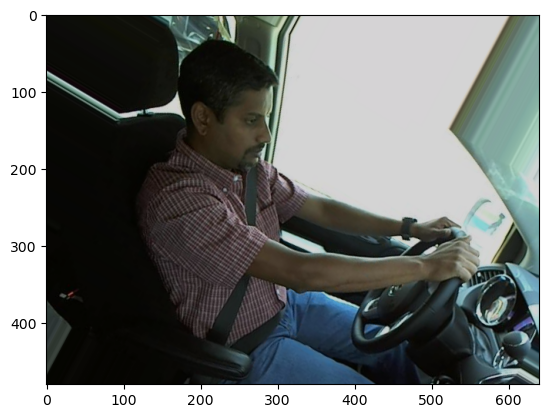

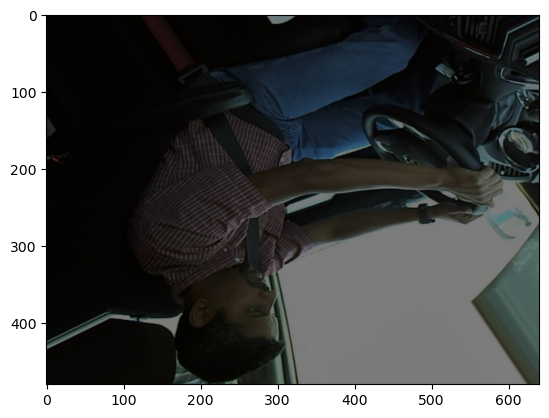

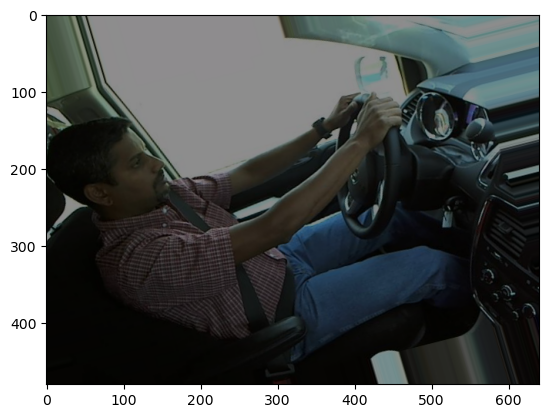

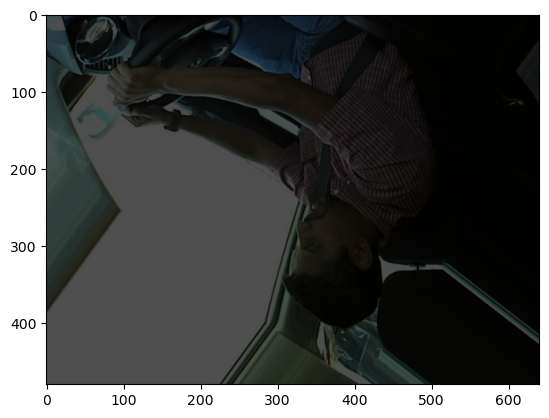

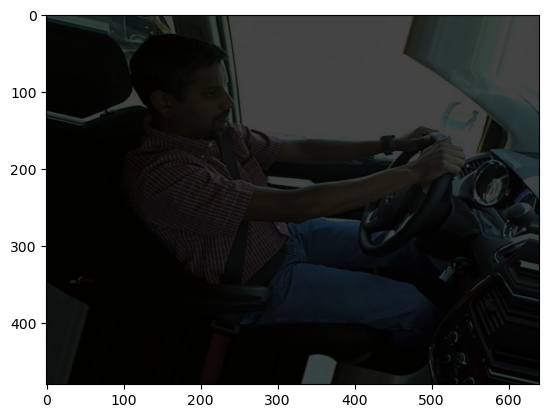

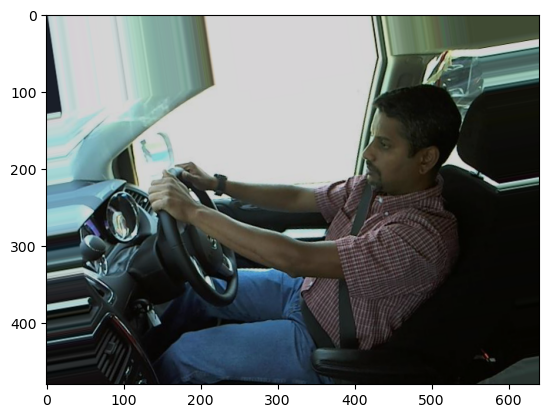

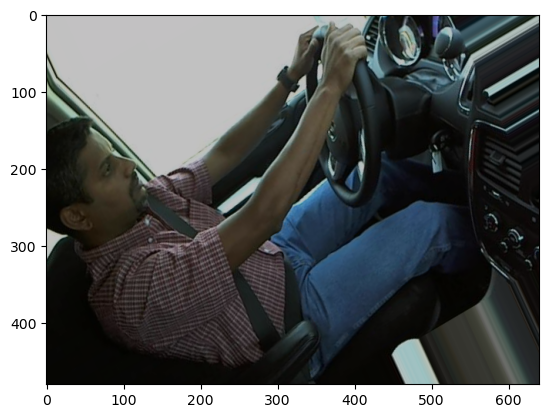

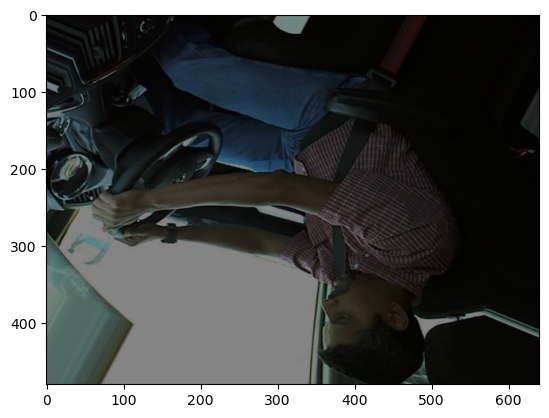

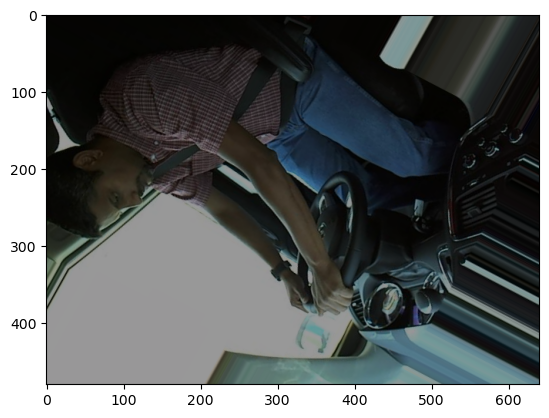

In [8]:
generator = ImageDataGenerator(rotation_range=40, zoom_range = 0.2, horizontal_flip = True, vertical_flip = True, fill_mode = "nearest", shear_range=0.2, width_shift_range = 0.1, brightness_range = [0.2, 1.0])

iterator = generator.flow(image,batch_size = 1)

for i in range(9):
    batch = iterator.next()
    new_image = batch[0].astype("uint8")
    plt.imshow(new_image)
    plt.show()


In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "imgs/train",
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(180, 180),
    label_mode = "categorical",
    batch_size=200)

Found 22424 files belonging to 10 classes.
Using 15697 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "imgs/train",
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(180, 180),
    label_mode = "categorical",
    batch_size=200)

Found 22424 files belonging to 10 classes.
Using 6727 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [12]:
model= Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)), # 归一化 normalization (n, m, 3)
    layers.Conv2D(filters=32,kernel_size = (3,3),  activation='relu'),
    layers.MaxPool2D(2,2),
    layers.Conv2D(filters=32,kernel_size = (3,3),  activation='relu'),
    layers.MaxPool2D(2,2),
    layers.Conv2D(filters=32,kernel_size = (3,3),  activation='relu'),
    layers.MaxPool2D(2,2),
    layers.Conv2D(filters=32,kernel_size = (3,3),  activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),

    layers.Dense(512,activation='relu'),
    layers.Dense(512,activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(10,activation = 'softmax') ## [0,1. 0.03, 0.21, 0.11]


])

model.compile(
    loss='categorical_crossentropy',
    metrics=['acc'],
    optimizer='adam'
)

In [14]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


AssertionError: 

In [13]:
history = model.fit(train_ds, epochs = 5, validation_data = val_ds)


Epoch 1/5
40/79 [==============>...............] - ETA: 1:40 - loss: 2.1429 - acc: 0.2023

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Evaluating model on validation data
# loss and accuracy
evaluate_train = model.evaluate(train_ds)
print(evaluate_train)
evaluate_val = model.evaluate(val_ds)
print(evaluate_val)